In [1]:
import sys

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import scipy.spatial
import torch

sys.path.append('../../../src')
from ovl.camera.camera_model import PinholeCameraModel
from ovl.rendering.mesh_rendering import CamMeshRenderer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
mesh = '/mnt/datasets/sk3d/dataset/dragon/stl/reconstruction/cleaned.ply'
mesh = o3d.io.read_triangle_mesh(mesh)

In [3]:
cam_model = '/mnt/datasets/sk3d/dataset/calibration/tis_right/rgb/cameras.txt'
cam_model = np.loadtxt(cam_model, usecols=range(2, 8))
cam_model = PinholeCameraModel(cam_model[2:4], cam_model[4:6], cam_model[:2].astype(int))

In [4]:
pose = '/mnt/datasets/sk3d/dataset/dragon/tis_right/rgb/images.txt'
pose = np.loadtxt(pose, usecols=range(1, 8))[99]

w2c = np.eye(4)
w2c[:3, 3] = pose[4:7]
w2c_xyzw = [*pose[1:4], pose[0]]; del pose
w2c[:3, :3] = scipy.spatial.transform.Rotation.from_quat(w2c_xyzw).as_matrix(); del w2c_xyzw
c2w = np.linalg.inv(w2c); del w2c
c2w_t, c2w_rot = c2w[:3, 3], c2w[:3, :3]; del c2w
c2w_t = torch.from_numpy(c2w_t).float()
c2w_rot = torch.from_numpy(c2w_rot).float()

In [5]:
renderer = CamMeshRenderer(mesh)

In [6]:
renderer.set_cam_model(cam_model)

In [7]:
renderer.set_cam_pose(c2w_t, c2w_rot)

In [8]:
render = renderer.render_pixels()            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/oyvoinov/.local/opt/miniconda3/envs/neusd_py310/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


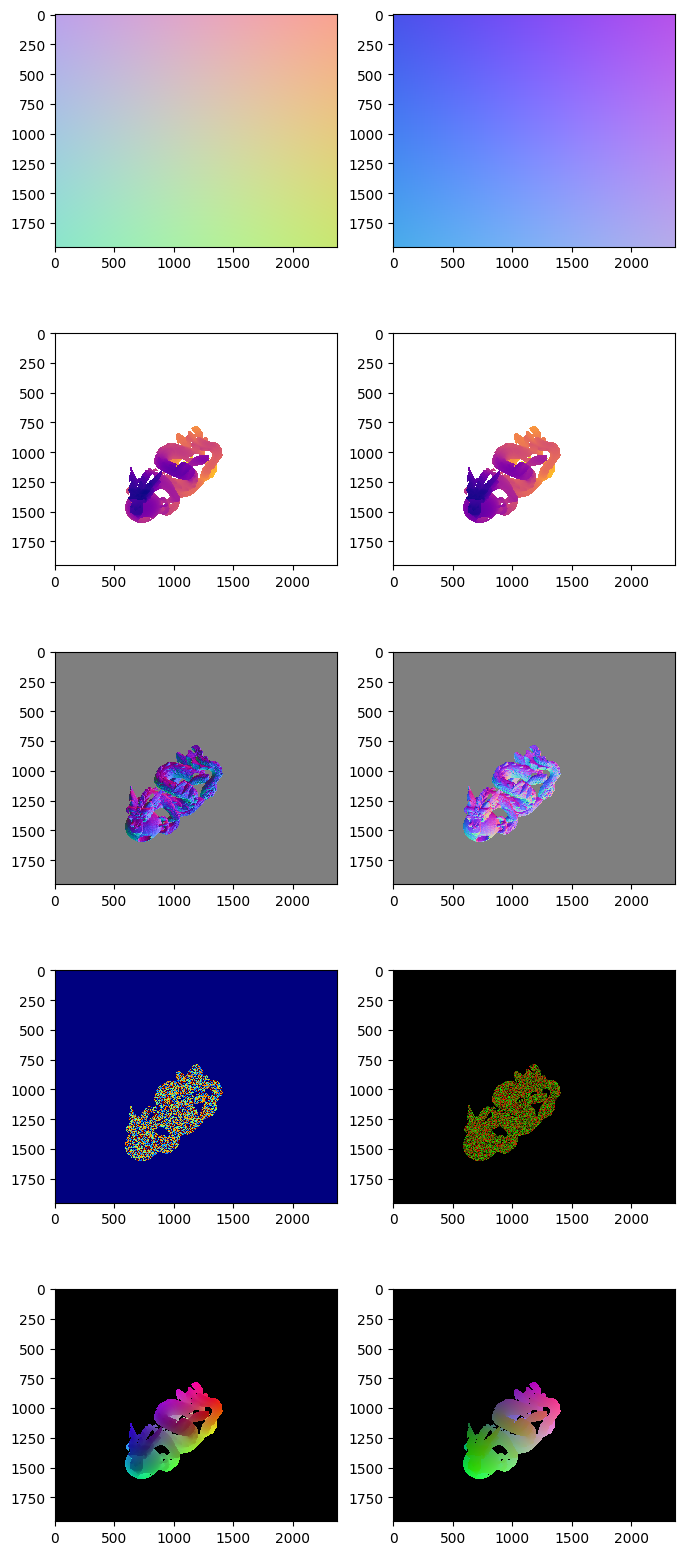

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(8, 20))

is_valid = render.depth_ray.isfinite()

for img, ax in zip([render.ray_dirs_world, render.ray_dirs_cam], axes[0]):
    img = img.add(1).div(2)
    ax.imshow(img, interpolation='none')

for img, ax in zip([render.depth_ray, render.depth_z], axes[1]):
    ax.imshow(img, cmap='plasma', interpolation='none')

for img, ax in zip([render.normals_world, render.normals_cam], axes[2]):
    img = img.add(1).div(2)
    img[..., 2] = 1 - img[..., 2]
    ax.imshow(img, interpolation='none')
    
img = render.tri_ids
img = img.remainder(5).div(5)
axes[3, 0].imshow(img, cmap='jet', interpolation='none')

img = render.uvs
img = torch.cat([img, torch.zeros_like(img[..., :1])], -1)
axes[3, 1].imshow(img, interpolation='none')

for img, ax in zip([render.xyz_world, render.xyz_cam], axes[4]):
    img = (img - img[is_valid].min(0).values) / (img[is_valid].max(0).values - img[is_valid].min(0).values)
    ax.imshow(img, interpolation='none')

plt.subplots_adjust()

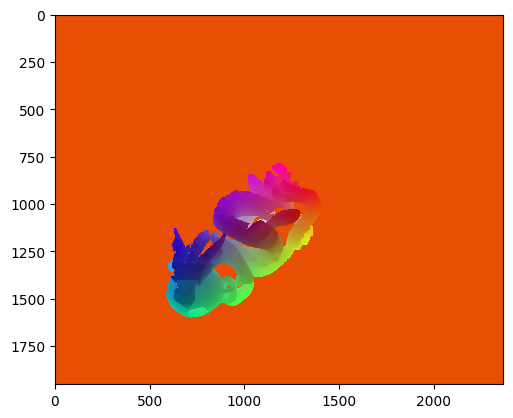

In [10]:
attrs = torch.from_numpy(renderer.mesh.vertex.positions.numpy())
render = renderer.render_pixels([attrs])

img = render.attr_samples[0]
img = (img - img[is_valid].min(0).values) / (img[is_valid].max(0).values - img[is_valid].min(0).values)
plt.imshow(img, interpolation='none')

Backface culling.

In [11]:
mesh = '/mnt/datasets/sk3d/dataset/animal_skulls/stl/reconstruction/cleaned.ply'
mesh = o3d.io.read_triangle_mesh(mesh)

In [12]:
poses = '/mnt/datasets/sk3d/dataset/animal_skulls/tis_right/rgb/images.txt'
poses = np.loadtxt(poses, usecols=range(1, 8))

w2cs = []
for i in [0, 11]:
    pose = poses[i]
    w2c = np.eye(4)
    w2c[:3, 3] = pose[4:7]
    w2c_xyzw = [*pose[1:4], pose[0]]; del pose
    w2c[:3, :3] = scipy.spatial.transform.Rotation.from_quat(w2c_xyzw).as_matrix(); del w2c_xyzw
    w2cs.append(w2c)

rot = w2cs[1] @ np.linalg.inv(w2cs[0])
    
c2w = np.linalg.inv(w2cs[0]) @ rot @ rot
c2w_t, c2w_rot = c2w[:3, 3], c2w[:3, :3]; del c2w
c2w_t = torch.from_numpy(c2w_t).float()
c2w_rot = torch.from_numpy(c2w_rot).float()

In [13]:
renderer = CamMeshRenderer(mesh)
renderer.set_cam_model(cam_model)
renderer.set_cam_pose(c2w_t, c2w_rot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


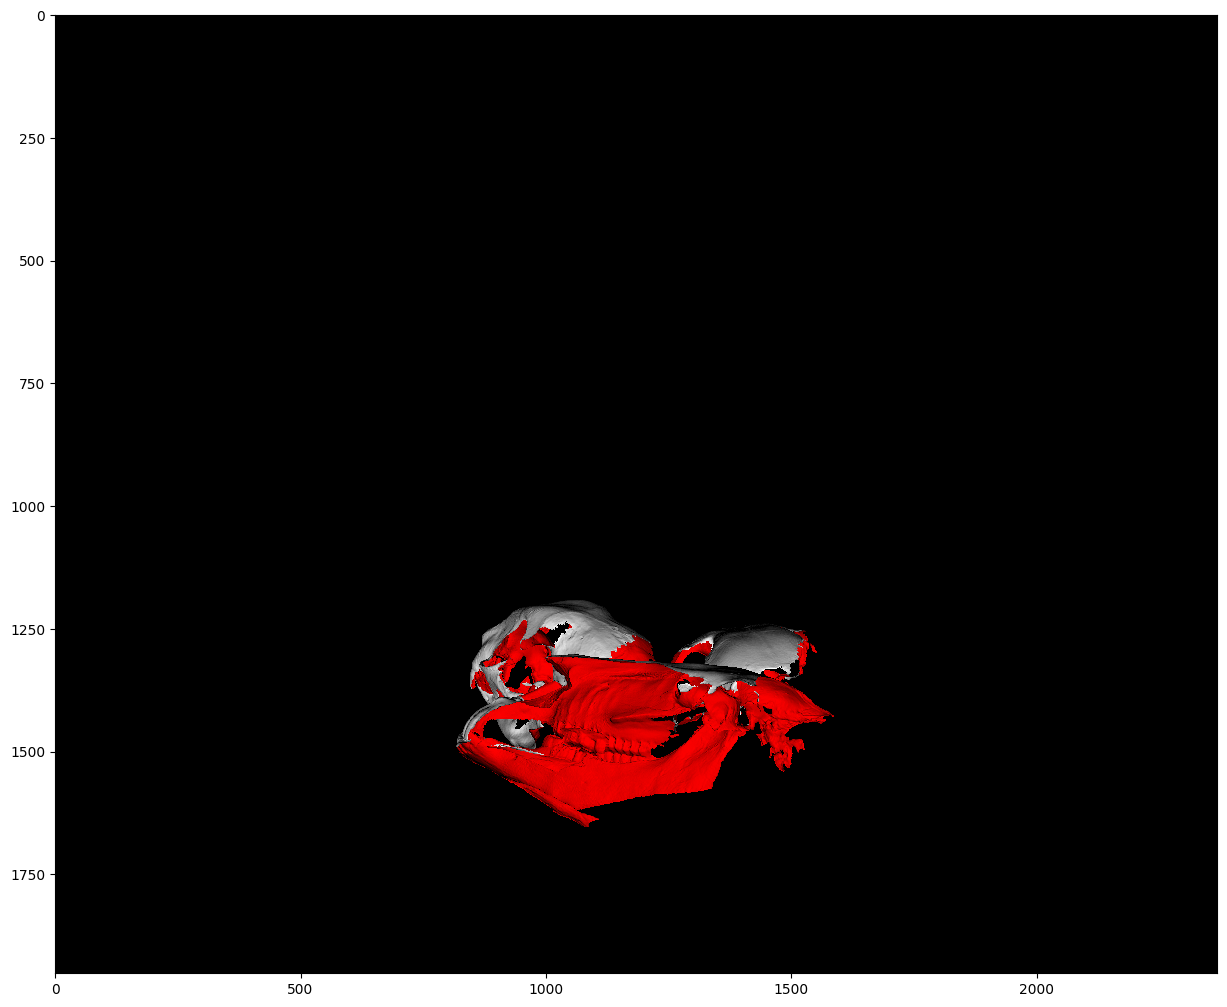

In [14]:
render = renderer.render_pixels()

nz = -render.normals_cam[..., 2]
is_valid = render.tri_ids != renderer.INVALID_ID
nz = nz.where(is_valid, nz.new_tensor(0))
is_front = render.is_frontfacing

img = nz.unsqueeze(2).expand(-1, -1, 3).clone()
img[~is_front] *= img.new_tensor([-1, 0, 0])

plt.figure(figsize=(15, 15))
plt.imshow(img.cpu(), interpolation='none')